In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1szhq3qf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1szhq3qf
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=7c3a813e6202f8babaf31f7290535894f46e07f93e6115ca03063b0e142962df
  Stored in directory: /tmp/pip-ephem-wheel-cache-i1fxx1e5/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import torch
import clip
from PIL import Image
from torchvision.datasets import Food101
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

# Load CLIP Model
def load_clip_model(device='cpu', backbone='ViT-B/16'):
    clip_model, preprocess = clip.load(backbone, device=device)
    return clip_model, preprocess

# Process Image with CLIP
def process_image_with_clip(image_path, clip_model, preprocess, device='cpu'):
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)  # Move image tensor to the device

    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    return image_features

# Predict the food class from CLIP
def predict_food_class(image_features, clip_model, dataset, device='cpu'):
    class_names = dataset.classes
    text_inputs = torch.cat([clip.tokenize(class_name) for class_name in class_names]).to(device)

    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)

    similarity = cosine_similarity(image_features.cpu().numpy(), text_features.cpu().numpy())
    predicted_class_index = similarity.argmax()
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

# Main function for CLIP-based prediction
def main(image_path, clip_model, preprocess, dataset, device='cpu'):
    image_features = process_image_with_clip(image_path, clip_model, preprocess, device)
    predicted_food_class = predict_food_class(image_features, clip_model, dataset, device)
    return predicted_food_class



In [ ]:
import torch
from torchvision.datasets import Food101
from torch.utils.data import Subset

test_dataset = Food101(root='/content/food101', split='test', download=True)
# Get the indices for the 50 images per class
class_indices = {}
for idx, (img, label) in enumerate(test_dataset):
    class_name = test_dataset.classes[label]
    if class_name not in class_indices:
        class_indices[class_name] = []
    if len(class_indices[class_name]) < 50:  # Only take 50 images per class
        class_indices[class_name].append(idx)

# Flatten the list of indices
selected_indices = [index for indices in class_indices.values() for index in indices]

# Create a subset of the dataset with 50 images per class
subset = Subset(test_dataset, selected_indices)

# Check how many images are in the subset
print(f"Subset size: {len(subset)}")


100%|██████████| 5.00G/5.00G [04:11<00:00, 19.8MB/s]


Extracting /content/food101/food-101.tar.gz to /content/food101
Subset size: 5050


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Define a transform to convert PIL Images to tensors and resize them
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),
])

# Create DataLoader for the subset, applying the transform
testset_loader = DataLoader(
    subset,
    batch_size=32,
    shuffle=False,
    # Modified collate_fn to stack images and labels correctly
    collate_fn=lambda batch: (torch.stack([transform(img) for img, _ in batch]), torch.tensor([label for _, label in batch]))
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_model(device)
dataset = Food101(root='/content/food101', split='train', download=True)

all_ground_truths = []
all_predictions = []

for images, labels in testset_loader:
    images = images.to(device)
    all_ground_truths.extend(labels.numpy())

    with torch.no_grad():
        image_features = clip_model.encode_image(images)

    predictions = []
    for image_feature in image_features:
        predicted_class = predict_food_class(image_feature.unsqueeze(0), clip_model, dataset, device)
        predictions.append(predicted_class)
    all_predictions.extend(predictions)

# Convert all_ground_truths to class names
all_ground_truth_names = [dataset.classes[label] for label in all_ground_truths]

accuracy = accuracy_score(all_ground_truth_names, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 49.6MiB/s]


Accuracy: 76.24%


In [ ]:
from sklearn.metrics import top_k_accuracy_score
import numpy as np

# Compute top-k accuracy
text_inputs = torch.cat([clip.tokenize(class_name) for class_name in dataset.classes]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)

all_image_features = []
all_ground_truths = []

for images, labels in testset_loader:
    images = images.to(device)
    labels = labels.numpy()
    all_ground_truths.extend(labels)

    with torch.no_grad():
        image_features = clip_model.encode_image(images)
        all_image_features.append(image_features.cpu().numpy())

all_image_features = np.concatenate(all_image_features)
all_ground_truths = np.array(all_ground_truths)

# Compute similarity
similarities = cosine_similarity(all_image_features, text_features.cpu().numpy())
top_k_accuracy = top_k_accuracy_score(all_ground_truths, similarities, k=5)  # Example for top-5
print(f"Top-5 Accuracy: {top_k_accuracy * 100:.2f}%")


Top-5 Accuracy: 94.93%


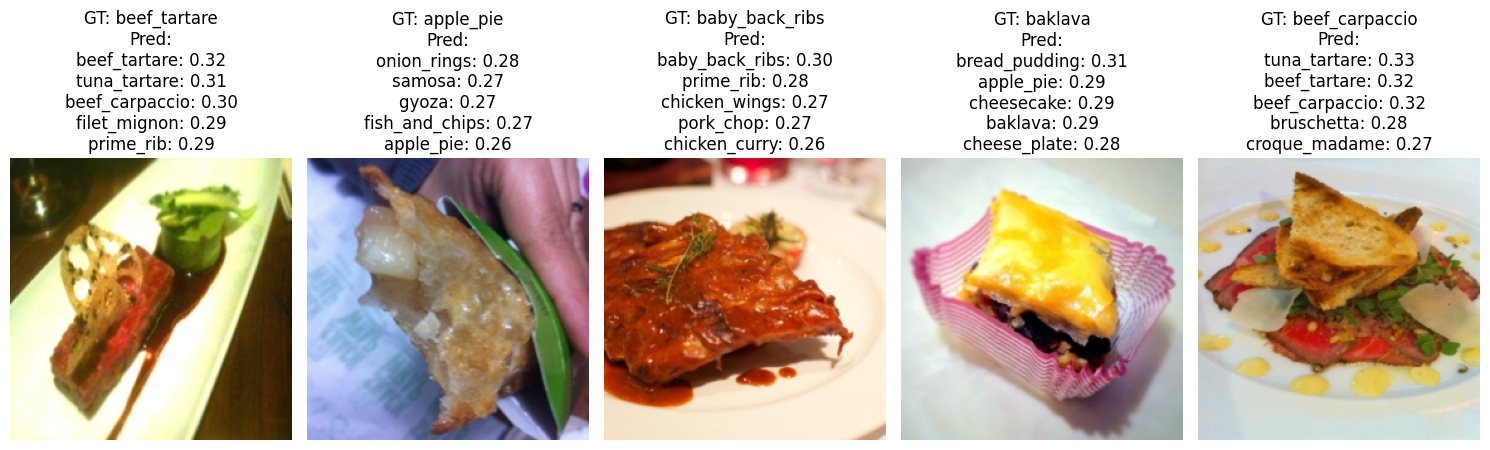

In [ ]:
import matplotlib.pyplot as plt

def plot_top_5_images(images, ground_truth, predictions, top_5_similarities, class_names):
    plt.figure(figsize=(15, 5))
    for i, (img, gt, sims, pred) in enumerate(zip(images, ground_truth, top_5_similarities, predictions)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())

        # Format top 5 similarities as a string
        sim_str = "\n".join([f"{class_names[pred_idx]}: {sim:.2f}" for pred_idx, sim in zip(pred, sims)])

        plt.title(f"GT: {class_names[gt]}\nPred:\n{sim_str}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Process first image of the first 5 classes
class_indices = list(range(5))  # First 5 classes
class_samples = {cls_idx: 0 for cls_idx in class_indices}
images_to_plot = []
ground_truths_to_plot = []
predicted_labels = []
top_5_similarities = []

for images, labels in testset_loader:
    for img, label in zip(images, labels):
        if label.item() in class_samples and class_samples[label.item()] == 0:
            # Process this image
            img = img.to(device)
            ground_truth = label.item()
            with torch.no_grad():
                img_features = clip_model.encode_image(img.unsqueeze(0)).cpu().numpy()
            sims = cosine_similarity(img_features, text_features.cpu().numpy())[0]
            top_5_idx = np.argsort(-sims)[:5]  # Top-5 predictions

            # Store results
            images_to_plot.append(img)
            ground_truths_to_plot.append(ground_truth)
            predicted_labels.append(top_5_idx)  # Top-1 prediction
            top_5_similarities.append(sims[top_5_idx])

            # Mark class as processed
            class_samples[ground_truth] += 1

        if all(count > 0 for count in class_samples.values()):
            break
    if all(count > 0 for count in class_samples.values()):
        break

# Plot
plot_top_5_images(images_to_plot, ground_truths_to_plot, predicted_labels, top_5_similarities, dataset.classes)


In [ ]:
import os
import json
import torch
from sentence_transformers import SentenceTransformer
import random

# Process Ingredients with CLIP (Text Embedding) using Sentence-BERT
def process_ingredients_with_clip(ingredients, clip_model, sentence_model, device='cpu'): # Add sentence_model as argument
    # Encode ingredients using Sentence-BERT
    ingredient_embedding = sentence_model.encode(ingredients)
    ingredient_embedding = torch.tensor(ingredient_embedding).unsqueeze(0).to(device) # Convert to tensor and move to device
    return ingredient_embedding

# Load Recipe Ingredients from JSON
def load_ingredients_json(ingredient_file="recipe_ingredients.json"):
    with open(ingredient_file, "r") as f:
        recipe_ingredients = json.load(f)
    return recipe_ingredients

# Create Combined Embedding for Image and Ingredients
def create_combined_embedding(image_features, ingredient_features):
    # Concatenate the image and ingredient features
    combined_embedding = torch.cat((image_features, ingredient_features), dim=-1)
    return combined_embedding

# Create Prototypes (Average of Embeddings for Few-Shot Learning)
def create_prototypes(image_paths, ingredient_data, clip_model, preprocess, sentence_model, device='cpu'):
    prototypes = {}

    for class_name in ingredient_data.keys():
        image_embeddings = []
        ingredient_embeddings = []

        for image_path in image_paths[class_name]:
            # Process image and ingredient for each sample
            image_features = process_image_with_clip(image_path, clip_model, preprocess, device)
            ingredients_str = ", ".join(json.loads(ingredient_data[class_name]))  # Join the ingredients
            # Pass sentence_model to process_ingredients_with_clip
            ingredient_features = process_ingredients_with_clip(ingredients_str, clip_model, sentence_model, device)

            combined_features = create_combined_embedding(image_features, ingredient_features)
            image_embeddings.append(combined_features)
            ingredient_embeddings.append(ingredient_features)

        # Create prototype for this class (average of embeddings)
        prototypes[class_name] = torch.mean(torch.stack(image_embeddings), dim=0)

    return prototypes

def create_prototypes_subset(image_paths, ingredient_data, clip_model, preprocess, sentence_model, device='cpu', num_samples_per_class=250):
    prototypes = {}

    for class_name in ingredient_data.keys():
        # Sample a subset of images from the class
        sampled_image_paths = random.sample(image_paths[class_name], num_samples_per_class)

        image_embeddings = []
        ingredient_embeddings = []

        for image_path in sampled_image_paths:
            # Process image and ingredient for each sample
            image_features = process_image_with_clip(image_path, clip_model, preprocess, device)
            ingredients_str = ", ".join(json.loads(ingredient_data[class_name]))  # Join the ingredients
            # Pass sentence_model to process_ingredients_with_clip
            ingredient_features = process_ingredients_with_clip(ingredients_str, clip_model, sentence_model, device)

            combined_features = create_combined_embedding(image_features, ingredient_features)
            image_embeddings.append(combined_features)
            ingredient_embeddings.append(ingredient_features)

        # Create prototype for this class (average of embeddings)
        prototypes[class_name] = torch.mean(torch.stack(image_embeddings), dim=0)

    return prototypes


# Predict Class Using Prototypes
def predict_food_class_with_ingredients(image_path, ingredient_data, clip_model, preprocess, prototypes, sentence_model, device='cpu'):
    # Process image and ingredients for the test sample
    image_features = process_image_with_clip(image_path, clip_model, preprocess, device)
    ingredients_str = ", ".join(json.loads(ingredient_data))  # Join the ingredients
    # Pass sentence_model to process_ingredients_with_clip
    ingredient_features = process_ingredients_with_clip(ingredients_str, clip_model, sentence_model, device)

    # Combine the features
    combined_features = create_combined_embedding(image_features, ingredient_features)

    # Compare with prototypes using cosine similarity
    similarities = {}
    for class_name, prototype in prototypes.items():
        similarity = cosine_similarity(combined_features.cpu().numpy(), prototype.cpu().numpy())
        similarities[class_name] = similarity

    # Get the class with the highest similarity
    predicted_class = max(similarities, key=similarities.get)
    return predicted_class

# Main Function to Train and Test
def train(image_paths, ingredient_file, clip_model, preprocess, device='cpu'):
    # Load ingredients data from JSON
    ingredient_data = load_ingredients_json(ingredient_file)

    # Initialize Sentence-BERT model
    sentence_model = SentenceTransformer('all-mpnet-base-v2')

    # Create a dictionary mapping class names to image paths
    image_paths = {}
    for class_name in dataset.classes:
        image_paths[class_name] = []
    # Assuming your images are organized in folders by class name under a base directory
    base_dir = '/content/food101/food-101/images'

    for class_name in dataset.classes:
        class_dir = os.path.join(base_dir, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image_paths[class_name].append(image_path)

    # Create prototypes for all classes (training step)
    prototypes = create_prototypes_subset(image_paths, ingredient_data, clip_model, preprocess, sentence_model, device)

     # Save the prototypes to a file
    prototype_file = "prototypes.pth"
    torch.save(prototypes, prototype_file)
    print(f"Prototypes saved to {prototype_file}")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
train(dataset, "recipe_ingredients.json", clip_model, preprocess, device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Prototypes saved to prototypes.pth


In [ ]:
import torch

# Load the prototypes from the file
prototype_file = "prototypes.pth"
prototypes = torch.load(prototype_file)

sentence_model = SentenceTransformer('all-mpnet-base-v2')

image_path = "/content/drive/My Drive/Final Project DL/images/bolognese.jpg"
ingredient_data = load_ingredients_json()["spaghetti_bolognese"]

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_model(device)
dataset = Food101(root='/content/food101', split='train', download=True)

<ipython-input-9-da58ca76539e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prototypes = torch.load(prototype_file)


In [ ]:
import torch
from sklearn.metrics import accuracy_score

# Load the prototypes from the file
prototype_file = "prototypes.pth"  # Use the same filename you used to save
prototypes = torch.load(prototype_file)

# Sentence model for ingredient embedding (not used for prediction in this case)
sentence_model = SentenceTransformer('all-mpnet-base-v2')

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = load_clip_model(device)
dataset = Food101(root='/content/food101', split='test', download=True)

# Function to predict class based on image features and prototypes
def predict_food_class_w_proto(image_features, prototypes):
    from sklearn.metrics.pairwise import cosine_similarity

    similarities = {}
    for class_name, prototype in prototypes.items():
        # Extract image features from the prototype (assuming first 512 dimensions are image features)
        image_prototype = prototype[:, :512]  # Extract the first 512 dimensions (image features)
        similarity = cosine_similarity(image_features.cpu().numpy(), image_prototype.cpu().numpy())
        similarities[class_name] = similarity

    predicted_class = max(similarities, key=similarities.get)
    return predicted_class

<ipython-input-10-8ede591cd518>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prototypes = torch.load(prototype_file)


In [ ]:
all_ground_truths_p = []
all_predictions_p = []

for images, labels in testset_loader:
    images = images.to(device)
    all_ground_truths_p.extend(labels.numpy())

    with torch.no_grad():
        image_features = clip_model.encode_image(images)

    predictions = []
    for image_feature in image_features:
        predicted_class = predict_food_class_w_proto(image_feature.unsqueeze(0), prototypes)
        predictions.append(predicted_class)
    all_predictions_p.extend(predictions)

# Convert all_ground_truths to class names
all_ground_truth_names_p = [dataset.classes[label] for label in all_ground_truths_p]

accuracy_p = accuracy_score(all_ground_truth_names_p, all_predictions_p)
print(f"Accuracy: {accuracy_p * 100:.2f}%")

Accuracy: 76.83%


In [ ]:
from sklearn.metrics import top_k_accuracy_score
import numpy as np

all_image_features_p = []
all_ground_truths_p = []

for images, labels in testset_loader:
    images = images.to(device)
    labels = labels.numpy()
    all_ground_truths_p.extend(labels)

    with torch.no_grad():
        image_features = clip_model.encode_image(images)
        all_image_features_p.append(image_features.cpu().numpy())

all_image_features_p = np.concatenate(all_image_features_p)
all_ground_truths_p = np.array(all_ground_truths_p)

# Compute similarity
prototype_features = np.array([prototype.cpu().numpy()[:, :512] for prototype in prototypes.values()])
prototype_features = prototype_features.reshape(prototype_features.shape[0], -1)  # Flatten the features
similarities_p = cosine_similarity(all_image_features_p, prototype_features)

class_indices = {class_name: i for i, class_name in enumerate(prototypes.keys())}
ground_truth_indices = [class_indices[dataset.classes[label]] for label in all_ground_truths_p]

top_k_accuracy_p = top_k_accuracy_score(ground_truth_indices, similarities_p, k=5)
print(f"Top-5 Accuracy: {top_k_accuracy_p * 100:.2f}%")


Top-5 Accuracy: 94.30%


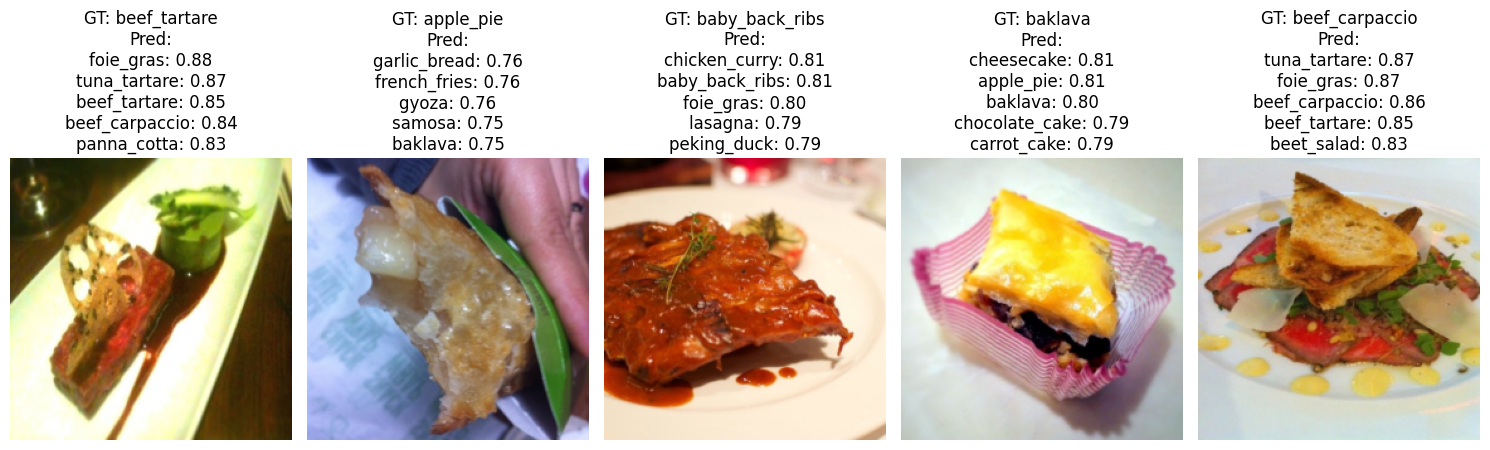

In [ ]:
import matplotlib.pyplot as plt

def plot_top_5_images_with_prototypes(images, ground_truth, predictions, top_5_similarities, prototype_classes, class_names):
    """Plot images with their ground truth, top-5 predicted prototype classes, and similarity scores."""
    plt.figure(figsize=(15, 5))
    for i, (img, gt, sims, pred) in enumerate(zip(images, ground_truth, top_5_similarities, predictions)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())

        # Format top-5 similarities as a string
        sim_str = "\n".join([f"{prototype_classes[pred_idx]}: {sim:.2f}" for pred_idx, sim in zip(pred, sims)])

        plt.title(f"GT: {class_names[gt]}\nPred:\n{sim_str}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Process first image of the first 5 classes
class_indices = list(range(5))  # First 5 classes
class_samples = {cls_idx: 0 for cls_idx in class_indices}
images_to_plot = []
ground_truths_to_plot = []
predicted_labels = []
top_5_similarities = []
prototype_classes = list(prototypes.keys())

for images, labels in testset_loader:
    for img, label in zip(images, labels):
        if label.item() in class_samples and class_samples[label.item()] == 0:
            # Process this image
            img = img.to(device)
            ground_truth = label.item()
            with torch.no_grad():
                img_features = clip_model.encode_image(img.unsqueeze(0)).cpu().numpy()
            sims = cosine_similarity(img_features, prototype_features)[0]
            top_5_idx = np.argsort(-sims)[:5]  # Top-5 predictions

            # Store results
            images_to_plot.append(img)
            ground_truths_to_plot.append(ground_truth)
            predicted_labels.append(top_5_idx)  # Top-5 predictions
            top_5_similarities.append(sims[top_5_idx])

            # Mark class as processed
            class_samples[ground_truth] += 1

        if all(count > 0 for count in class_samples.values()):
            break
    if all(count > 0 for count in class_samples.values()):
        break

# Plot the results
plot_top_5_images_with_prototypes(images_to_plot, ground_truths_to_plot, predicted_labels, top_5_similarities, prototype_classes, dataset.classes)